In [1]:
import firedrake
import matplotlib.pyplot as plt
import icepack.plot
from firedrake import inner, as_vector
import icepack
from firedrake import ds
import numpy as np
import math


firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [4]:
# Read in the mesh used in the Elmer/Ice simulations

sim = 'Flux300Sigma5000' # also run: 'Flux50Sigma5000', 'Flux300Sigma1000', 'Flux300Sigma5000'
mesh2d = firedrake.Mesh('Mesh/' + sim + '.msh')
mesh = firedrake.ExtrudedMesh(mesh2d, layers=1)


In [54]:
#Plot the mesh

# fig, axes = icepack.plot.subplots()
# icepack.plot.triplot(mesh, axes=axes)
# axes.legend();


In [55]:

# x, y = firedrake.SpatialCoordinate(mesh)

In [56]:
# Define the function spaces

# Q = firedrake.FunctionSpace(mesh, "CG", 2)
# V = firedrake.VectorFunctionSpace(mesh, "CG", 2)

In [7]:
Q = firedrake.FunctionSpace(
    mesh, "CG", 2, vfamily="R", vdegree=0
)

In [8]:
V = firedrake.VectorFunctionSpace(
    mesh, "CG", 2, dim=2, vfamily="GL", vdegree=2
)

In [9]:
from icepack.constants import (
    ice_density as ρ_I,
    water_density as ρ_W,
    weertman_sliding_law as m,
    gravity as g,
)

x, y, ζ = firedrake.SpatialCoordinate(mesh)

In [10]:

b = -600.0
b = firedrake.Constant(b, Q)

s = 30.0
s0 = firedrake.Constant(s, Q)
s0 = firedrake.interpolate(s0, Q)

h = 300.0
h0 = firedrake.Constant(h, Q)

/Users/guymoss/Documents/Python_Envs/firedrake/src/firedrake/firedrake/constant.py:63: FutureWarning: Giving Constants a domain is no longer supported. Instead please create a Function in the Real space.
  warnings.warn(
/Users/guymoss/Documents/Python_Envs/firedrake/src/firedrake/firedrake/constant.py:63: FutureWarning: Giving Constants a domain is no longer supported. Instead please create a Function in the Real space.
  warnings.warn(


In [11]:
h_in = h0
sdiff = 0.0
δs_δy = firedrake.Constant(sdiff, Q)
τ_D = -ρ_I * g * h_in * δs_δy

In [12]:
# Define the inflow boundary velocity and thickness
u_out = 0.0 #initial guess at what the outflow velocity should be
u_in = 300.0 #velocity at inflow boundary (kept fixed through simulation)
h_in = 300.0 #inflow thickness (also kept constant)
Ly = 1.5e5

#Define regular shelf flow, but with circular repression around the centre of the ice rise
center = [1.5e5, 0.75e5]
distance = firedrake.interpolate(firedrake.sqrt((x-center[0])**2 + (y-center[1])**2),Q)
#where distance==min_dist is where the boundary of the domain is
min_dist = distance.dat.data.min()

u_0_x = 0.0
u_0_y = firedrake.min_value(u_in + (u_out - u_in) * (y/Ly), 0.5 * (distance-min_dist))


In [13]:

h_expr = firedrake.Constant(h_in)
h0 = firedrake.interpolate(h_expr, Q)
u0 = firedrake.interpolate(firedrake.as_vector((u_0_x,u_0_y)), V)


In [14]:
yearinsec = 365.25*24*60*60
A = 4.6e-25*yearinsec*1.0e18
A = firedrake.Constant(A)


In [15]:
expr = (0.95 - 0.05 * y / Ly) * τ_D / u_in**(1 / m)
C = firedrake.interpolate(expr, Q)

p_W = ρ_W * g * firedrake.max_value(0, h0 - s0)
p_I = ρ_I * g * h0
ϕ = 1 - p_W / p_I

In [16]:
import icepack.models.hybrid

def friction(**kwargs):
    u = kwargs["velocity"]
    h = kwargs["thickness"]
    s = kwargs["surface"]
    C = kwargs["friction"]

    p_W = ρ_W * g * firedrake.max_value(0, h - s)
    p_I = ρ_I * g * h
    ϕ = 1 - p_W / p_I
    return icepack.models.hybrid.bed_friction(
        velocity=u,
        friction=C * ϕ,
    )

In [17]:
model = icepack.models.HybridModel(friction=friction)
opts = {
    "dirichlet_ids": [9,13],
    "side_wall_ids": [10,12],
}
solver = icepack.solvers.FlowSolver(model, **opts)

u0 = solver.diagnostic_solve(
    velocity=u0,
    thickness=h0,
    surface=s0,
    fluidity=A,
    friction=C,
)

In [18]:
# Set A(T)

#T = firedrake.Constant(255.15)
#A = icepack.rate_factor(T)

yearinsec = 365.25*24*60*60
A = 4.6e-25*yearinsec*1.0e18
A = firedrake.Constant(A)


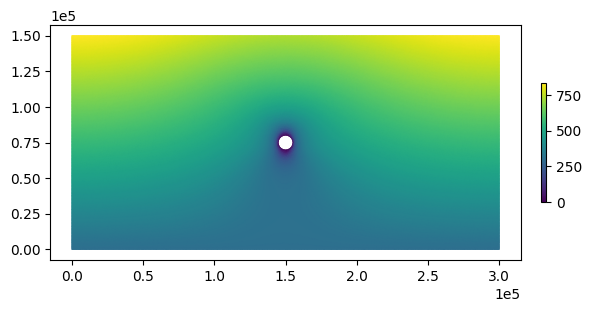

In [19]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u0, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04);

In [20]:
import tqdm

num_years = 2
timesteps_per_year = 2

δt = 1.0 / timesteps_per_year
num_timesteps = num_years * timesteps_per_year

a = firedrake.Constant(0.0)
h = h0.copy(deepcopy=True)
u = u0.copy(deepcopy=True)

for step in tqdm.trange(num_timesteps):
    h = solver.prognostic_solve(
        δt,
        thickness=h,
        velocity=u,
        accumulation=a,
        thickness_inflow=h0,
    )
    s = icepack.compute_surface(thickness=h, bed=b)
    
    u = solver.diagnostic_solve(
        velocity=u,
        thickness=h,
        surface=s,
        fluidity=A,
        friction=C,
    )

100%|██████████| 4/4 [02:48<00:00, 42.21s/it]


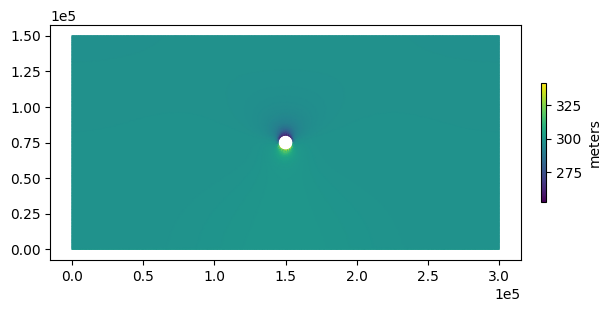

In [21]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(h, axes=axes)
fig.colorbar(colors, label="meters", fraction=0.012, pad=0.04);

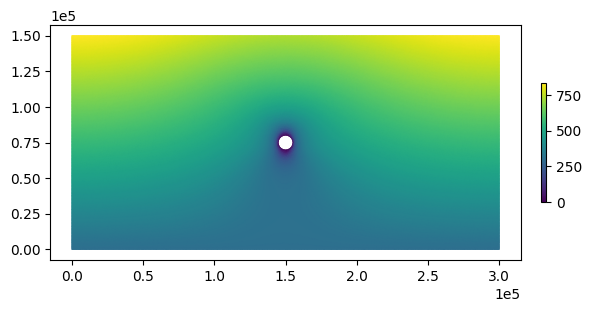

In [22]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(u0, axes=axes)
fig.colorbar(colors, ax=axes, fraction=0.012, pad=0.04);

In [41]:
from icepack.models.viscosity import membrane_stress
from firedrake import sym, grad, sqrt, tr

#For this part we work on the footprint mesh!
Q_c = firedrake.FunctionSpace(mesh2d, "CG", 2)
S = firedrake.TensorFunctionSpace(mesh2d, "DG", 1)
#Calculate the depth-averaged velocity - for weighted average look at icepack tutorial on hybrid model(xyz)
u_shear = icepack.depth_average(u) 
ε = firedrake.project(sym(grad(u_shear)), S)

ε_e = firedrake.project(1e3 * sqrt(inner(ε, ε) + tr(ε) ** 2), Q_c)

degree = 2 * ε.ufl_element().degree()
params = {
    "form_compiler_parameters": {
        "quadrature_degree": degree
    }
}

# ε = firedrake.Function(S)
M = firedrake.Function(S)

# ε.project(sym(grad(u)))
expr = membrane_stress(strain_rate=ε, fluidity=A)
M.project(expr, **params)


Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x1b4df4670>, TensorElement(FiniteElement('Discontinuous Lagrange', triangle, 1), shape=(2, 2), symmetry={}), name=None), Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 6)), 267)

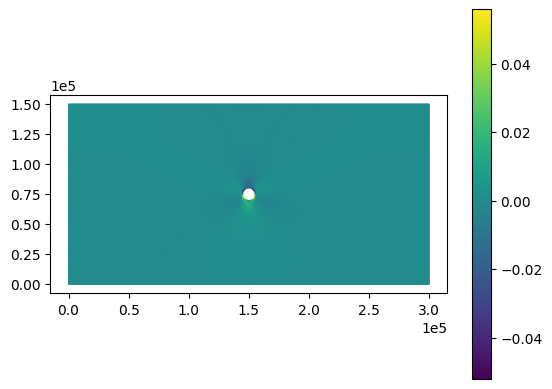

In [42]:
εxx = firedrake.interpolate(ε[0, 0],Q_c)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(εxx, axes=axes)
fig.colorbar(colors);


In [46]:
h_c = icepack.depth_average(h) #the depth-averaged thickness is obvioulsy just the thickness, but we need to get a quantity defined on the footprint mesh.

year = 365.25 * 24 * 60 * 60 # number of seconds in a year
g = 9.81 * year**2 # [m a^{-1}]
rho_i = 900 / year**2 * 1.0e-6 #[MPa m^{-2} a^2]
#sigma_xx = firedrake.interpolate(2 * M[0,0]*h + M[1,1]*h - 0.5 * rho_i * g * h**2, Q)
#sigma_yy = firedrake.interpolate(2 * M[1,1]*h + M[0,0]*h - 0.5 * rho_i * g * h**2, Q)
sigma_xx = firedrake.interpolate(2 * M[0,0]*h_c + M[1,1]*h_c - 0.5 * rho_i * g * h_c**2, Q_c)
sigma_yy = firedrake.interpolate(2 * M[1,1]*h_c + M[0,0]*h_c - 0.5 * rho_i * g * h_c**2, Q_c)
sigma_nhp_xx = firedrake.interpolate(2 * M[0,0]*h_c + M[1,1]*h_c, Q_c)
sigma_nhp_yy = firedrake.interpolate(2 * M[1,1]*h_c + M[0,0]*h_c, Q_c)
Mxx = firedrake.interpolate(M[0,0]*h_c, Q_c) # 
Myy = firedrake.interpolate(M[1,1]*h_c, Q_c) # 
HP = firedrake.interpolate( - 0.5 * rho_i * g * h_c**2, Q_c) # negative


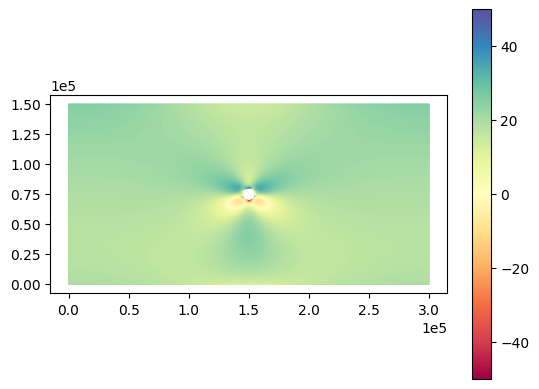

In [47]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(Mxx, axes=axes, vmin=-50, vmax=50, cmap="Spectral")
fig.colorbar(colors);

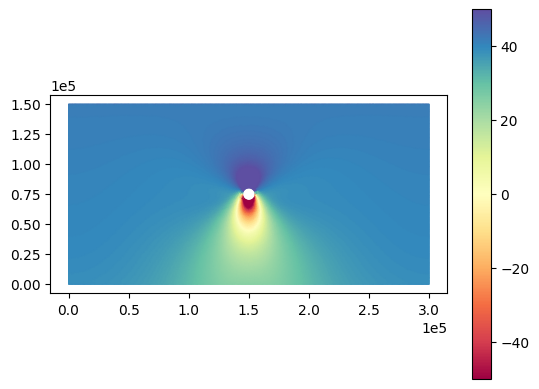

In [48]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(Myy, axes=axes, vmin=-50, vmax=50, cmap="Spectral")
fig.colorbar(colors);

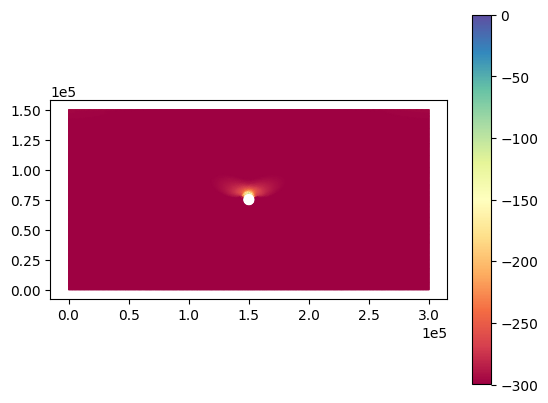

In [49]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_xx, axes=axes, vmin=-300, vmax=0, cmap="Spectral")
fig.colorbar(colors);

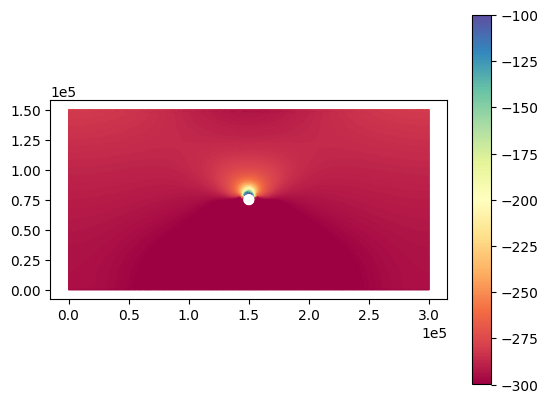

In [50]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_yy, axes=axes, vmin=-300, vmax=-100, cmap="Spectral")
fig.colorbar(colors);

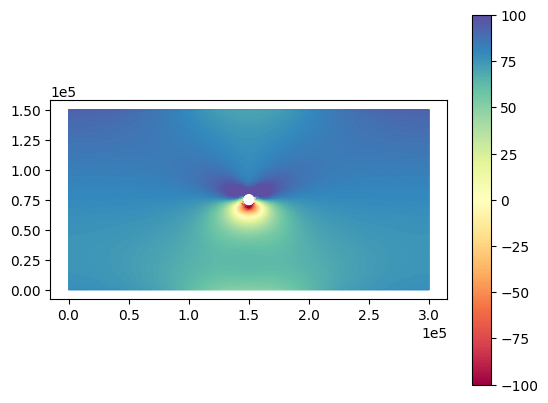

In [51]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_nhp_xx, axes=axes, vmin=-100, vmax=100, cmap="Spectral")
fig.colorbar(colors);

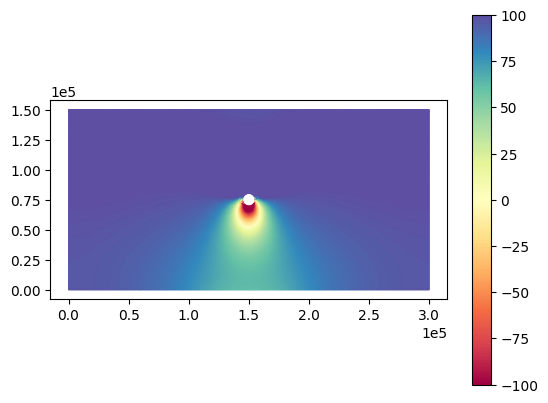

In [52]:
fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(sigma_nhp_yy, axes=axes, vmin=-100, vmax=100, cmap="Spectral")
fig.colorbar(colors);

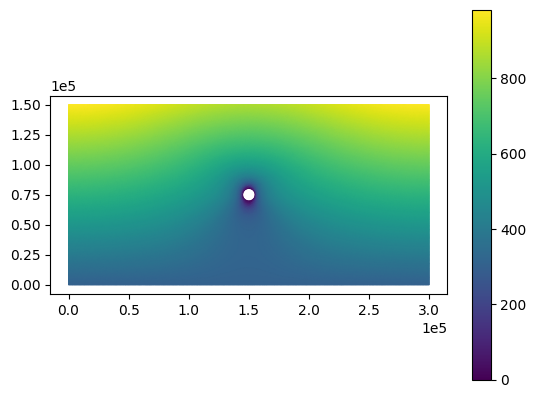

In [53]:
vy = firedrake.interpolate(u[1],Q)

fig, axes = icepack.plot.subplots()
colors = icepack.plot.tripcolor(vy, axes=axes)
fig.colorbar(colors);